## load data 

### load train data

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os 
IMG_SIZE=224
DATADIR="/content/drive/My Drive/fundus_cross_validation/TRAIN"
CATEGORIES=["healthy","glaucoma","myopia","maculopathy","retinitispigmentosa"]

training_data=[]
def create_training_data():
  for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    class_num=CATEGORIES.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      
      img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) 
      new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      training_data.append([new_array,class_num])
create_training_data()

In [ ]:
import random
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
def preparedata():
  random.shuffle(training_data)
  '''
  train=[]
  test=[]
  for sample in training_data:
    randprob=random.randint(0,10)
    if (randprob<8):
      train.append(sample)
    else:
      test.append(sample)
  '''
  train,test=train_test_split(training_data,test_size=0.20, shuffle=True)
  
  x=[]
  y=[]
  for features, label in train:
   x.append(features)
   y.append(label)
  x=np.array(x).reshape(-1,IMG_SIZE,IMG_SIZE,3)
  X=x/255.0
  Y=np.array(y)
  #print(Y)

  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(Y)
  #print(integer_encoded)

  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  #print(onehot_encoded)
  #Y=np.array(onehot_encoded)
  #print(Y)

  ytest=[]
  xtest=[]
  for features, label in test:
   ytest.append(label)
   xtest.append(features)
  xtest=np.array(xtest).reshape(-1,IMG_SIZE,IMG_SIZE,3)
  Ytest=np.array(ytest)
  Xtest=xtest/255.0
  #print(Ytest)
  #print(len(train))
  #print(len(test))
  return X,Y,Xtest,Ytest

## model

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [ ]:
X,Y,Xtest,Ytest=preparedata()
image_batch=X[:4]

image_batch.shape

In [ ]:
def makemodel():
   IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

   # Create the base model from the pre-trained model MobileNet V2
   base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
   feature_batch = base_model(image_batch)
   base_model.trainable = False
 
   global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
   feature_batch_average = global_average_layer(feature_batch)
   prediction_layer = tf.keras.layers.Dense(5)
   
   prediction_batch = prediction_layer(feature_batch_average)
   modelname = tf.keras.Sequential([
   base_model,
   global_average_layer,
   
   prediction_layer,
   ])
   base_learning_rate = 0.1

   modelname.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
   
   return modelname, base_model

In [ ]:
def finetunedmodel(modelname,base_model,finetuneAt=152):
  
  base_model.trainable = True
  print("before",len(base_model.trainable_variables))
  
  for layer in base_model.layers[:finetuneAt]:
      layer.trainable = False
  print("after",len(base_model.trainable_variables))
  modelname.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return modelname

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def train(repeatimes, epochs):
   from tensorflow.keras.callbacks import EarlyStopping
   historys=[]
   historys_fine=[]
   models=[]
   basemodels=[]
   Xtests=[]
   Ytests=[]
   times=[]
   for r in range(repeatimes):
      m,b=makemodel()
      models.append(m)
      basemodels.append(b)
      
   for repeat in range(repeatimes):
     X,Y,Xtest,Ytest=preparedata()
     start=time.time()
     #callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
     history = models[repeat].fit(X,Y,batch_size=4,epochs=epochs)
     models[repeat]=finetunedmodel(models[repeat],basemodels[repeat],152)
     
     history_fine=models[repeat].fit(X,Y,batch_size=4,epochs=30)
     end=time.time()
     Xtests.append(Xtest)
     Ytests.append(Ytest)
     historys.append(history)
     historys_fine.append(history_fine)
     t=end-start
     times.append(t)
     tf.keras.backend.clear_session()
   return historys,historys_fine,Xtests,Ytests,models,times

In [ ]:
historys,historys_fine,Xtests,Ytests,models,times=train(5,15)

[3 2 0 3 2 3 1 3 1 4 1 0 4 0 4 1 3 2 1 1 0 3 3 1 4 1 2 3 2 2 3 0 2 4 1 1 4
 4 2 3 3 2 2 2 2 4 3 1 3 3 3 3 1 1 0 4 3 1 2 4 2 0 1 0 0 1 1 2 2 3 3 2 3 1
 2 3 3 1 3 1 2 3 1 4 0 2 0 1 1 4 4 4 3 1 0 1 0 1 0 1 0 3 3 4 1 2 1 3 2 3 1
 1 2 1 1 1 1 3 2 1 0 2 3 2 0 2 2 3 2 3 2 3 1 3 3 1 2 3 0 2 2 2 1 4 2 3 1 1
 1 4 1 3 3 1 3 0 1 1 3 1 3 1 0 3 1 0 0 2 4 3 0 3 1 1 1 1 3 1 2 3 3 1 3 1 1
 2 0 2 3 3 2 1 0 1 2 1 1 3 2 4]
[3 2 0 3 2 3 1 3 1 4 1 0 4 0 4 1 3 2 1 1 0 3 3 1 4 1 2 3 2 2 3 0 2 4 1 1 4
 4 2 3 3 2 2 2 2 4 3 1 3 3 3 3 1 1 0 4 3 1 2 4 2 0 1 0 0 1 1 2 2 3 3 2 3 1
 2 3 3 1 3 1 2 3 1 4 0 2 0 1 1 4 4 4 3 1 0 1 0 1 0 1 0 3 3 4 1 2 1 3 2 3 1
 1 2 1 1 1 1 3 2 1 0 2 3 2 0 2 2 3 2 3 2 3 1 3 3 1 2 3 0 2 2 2 1 4 2 3 1 1
 1 4 1 3 3 1 3 0 1 1 3 1 3 1 0 3 1 0 0 2 4 3 0 3 1 1 1 1 3 1 2 3 3 1 3 1 1
 2 0 2 3 3 2 1 0 1 2 1 1 3 2 4]
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1

In [ ]:
for history in historys:
  acc = history.history['accuracy']
  print(acc)

[0.6150000095367432, 0.7950000166893005, 0.824999988079071, 0.8949999809265137, 0.8899999856948853, 0.9300000071525574, 0.9399999976158142, 0.9300000071525574, 0.9399999976158142, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6349999904632568, 0.7799999713897705, 0.8100000023841858, 0.8799999952316284, 0.9049999713897705, 0.9100000262260437, 0.8999999761581421, 0.9350000023841858, 0.9900000095367432, 0.9350000023841858, 0.9750000238418579, 0.9649999737739563, 1.0, 1.0, 1.0]
[0.6050000190734863, 0.7450000047683716, 0.8399999737739563, 0.8600000143051147, 0.8949999809265137, 0.9350000023841858, 1.0, 0.9449999928474426, 1.0, 0.949999988079071, 0.9750000238418579, 0.9700000286102295, 0.9399999976158142, 0.9300000071525574, 0.9800000190734863]
[0.5799999833106995, 0.800000011920929, 0.8799999952316284, 0.8799999952316284, 0.9049999713897705, 0.9150000214576721, 0.9399999976158142, 0.949999988079071, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5550000071525574, 0.7950000166893005, 0.8199999928474426, 0.875, 0.

In [ ]:
for time in times:
  print(time)

23.346339225769043
24.898123264312744
24.20592498779297
25.00761866569519
25.037127256393433


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


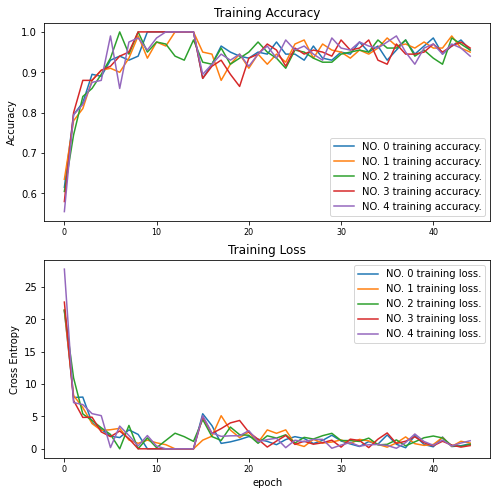

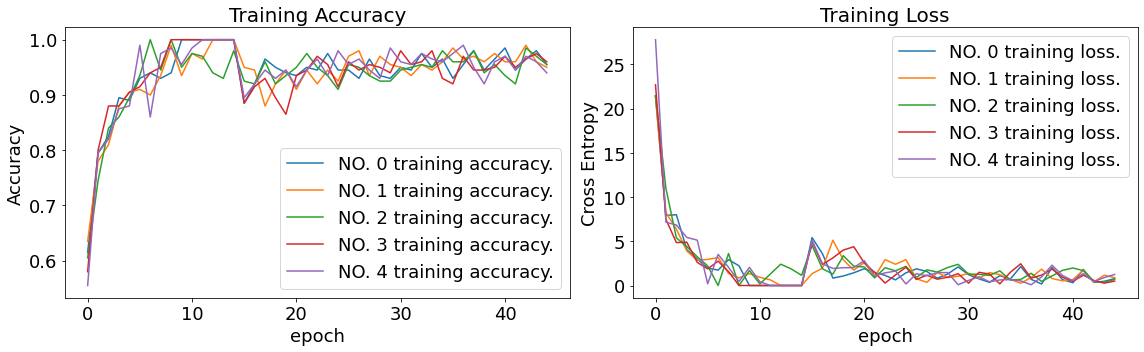

In [ ]:
plt.figure(figsize=(8, 8))
count=0

for history,history_fine in zip(historys,historys_fine):
  tr = 'NO. %d training accuracy.' % (count)
  te = 'NO. %d training loss.' % (count)
 
  acc = history.history['accuracy']+history_fine.history['accuracy']
  loss = history.history['loss']+history_fine.history['loss']



  plt.subplot(2, 1, 1)
  plt.plot(acc, label=tr)
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')

  plt.title('Training Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label=te)
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')

  plt.title('Training Loss')
  plt.xlabel('epoch')
  
  count=count+1
plt.show()
fig,axes=plt.subplots(1,2,figsize=(16,5))
count=0
for history,history_fine in zip(historys,historys_fine):
  tr = 'NO. %d training accuracy.' % (count)
  te = 'NO. %d training loss.' % (count)
  acc = history.history['accuracy']+history_fine.history['accuracy']
  loss = history.history['loss']+history_fine.history['loss']



  
  plt.rc('xtick',labelsize=8)


  axes[0].plot(acc, label=tr)
  axes[0].tick_params(axis="x", labelsize=18)
  axes[0].tick_params(axis="y", labelsize=18)

  axes[0].legend(loc='lower right',fontsize=18)
  axes[0].set_ylabel('Accuracy',fontsize=18)
  axes[0].patch.set_facecolor("w")
  axes[0].set_title('Training Accuracy',fontsize=20)
  axes[0].set_xlabel('epoch',fontsize=18)
#axes[0].grid(None)

  axes[0].spines['left'].set_color('black') 
  axes[0].spines['bottom'].set_color('black') 
  axes[0].spines['right'].set_color('black') 
  axes[0].spines['top'].set_color('black')



  axes[1].plot(loss, label=te)
  axes[1].legend(loc='upper right',fontsize=18)
  axes[1].set_ylabel('Cross Entropy',fontsize=18)
  axes[1].patch.set_facecolor("w")
  axes[1].set_title('Training Loss',fontsize=20)
  axes[1].set_xlabel('epoch',fontsize=18)
#plt.grid(None)
  axes[1].tick_params(axis="x", labelsize=18)
  axes[1].tick_params(axis="y", labelsize=18)

  axes[1].spines['left'].set_color('black') 
  axes[1].spines['bottom'].set_color('black') 
  axes[1].spines['right'].set_color('black') 
  axes[1].spines['top'].set_color('black') 
  plt.tight_layout()
  count=count+1
plt.show()

## testing

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
def testfuc(Xtest,Ytest,model):
  probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
  predictions = probability_model.predict(Xtest)
  #print(predictions)


  FINNAL_CLASIFICATION=[]
  for r in predictions:
   c=np.argmax(r)
   FINNAL_CLASIFICATION.append(c)
  FINNAL_CLASIFICATION=np.array(FINNAL_CLASIFICATION)
  #print(FINNAL_CLASIFICATION)
  #print(Ytest)
  C = multilabel_confusion_matrix(Ytest, FINNAL_CLASIFICATION)

  tp = C[:, 1, 1]
  tn = C[:, 0, 0]
  fn = C[:, 1, 0]
  fp = C[:, 0, 1]

  acc=(sum(tn)+sum(tp))/(sum(tn)+ sum(fp)+ sum(fn)+sum(tp))
  sen= sum(tp) / (sum(tp)+sum(fn))
  spec = sum(tn) / (sum(tn) + sum(fp))
  print(acc)
  print(sen)
  print(spec)
  return acc,sen,spec

In [ ]:
accs=[]
sens=[]
specs=[]
for i in range(len(historys)):
  acc,sen,spec=testfuc(Xtests[i],Ytests[i],models[i])
  accs.append(acc)
  sens.append(sen)
  specs.append(spec)
print('***************')
print(accs)
print(sens)
print(specs)
print('****************')
print(sum(accs)/len(historys))
print(sum(sens)/len(historys))
print(sum(specs)/len(historys))
print("time",sum(times)/len(historys))

0.96
0.9
0.975
0.944
0.86
0.965
0.984
0.96
0.99
0.96
0.9
0.975
0.96
0.9
0.975
***************
[0.96, 0.944, 0.984, 0.96, 0.96]
[0.9, 0.86, 0.96, 0.9, 0.9]
[0.975, 0.965, 0.99, 0.975, 0.975]
****************
0.9616
0.9039999999999999
0.976
time 24.499026679992674


# DNN

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(1000)
image_batch=X[:4]

image_batch.shape 
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
def makeDNN():  
  # (3) Create a sequential model
  DNN = Sequential()

  # 1st Convolutional Layer
  DNN.add(Conv2D(filters=96, input_shape=IMG_SHAPE, kernel_size=(11,11),\
   strides=(4,4), padding='valid'))
  DNN.add(Activation('relu'))
  # Pooling 
  DNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # Batch Normalisation before passing it to the next layer
  DNN.add(BatchNormalization())

  # 2nd Convolutional Layer
  DNN.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
  DNN.add(Activation('relu'))
  # Pooling
  DNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # Batch Normalisation
  DNN.add(BatchNormalization())

  # 3rd Convolutional Layer
  DNN.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  DNN.add(Activation('relu'))
  # Batch Normalisation
  DNN.add(BatchNormalization())

  # 4th Convolutional Layer
  DNN.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  DNN.add(Activation('relu'))
  # Batch Normalisation
  DNN.add(BatchNormalization())

  # 5th Convolutional Layer
  DNN.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
  DNN.add(Activation('relu'))
  # Pooling
  DNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  # Batch Normalisation
  DNN.add(BatchNormalization())

  # Passing it to a dense layer
  DNN.add(Flatten())
  # 1st Dense Layer
  DNN.add(Dense(4096, input_shape=(224*224*3,)))
  DNN.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  DNN.add(Dropout(0.4))
  # Batch Normalisation
  DNN.add(BatchNormalization())

  # 2nd Dense Layer
  DNN.add(Dense(4096))
  DNN.add(Activation('relu'))
  # Add Dropout
  DNN.add(Dropout(0.4))
  # Batch Normalisation
  DNN.add(BatchNormalization())

  # 3rd Dense Layer
  DNN.add(Dense(1000))
  DNN.add(Activation('relu'))
  # Add Dropout
  DNN.add(Dropout(0.4))
  # Batch Normalisation
  DNN.add(BatchNormalization())

  # Output Layer
  DNN.add(Dense(5))
  #model.add(Activation('softmax'))


  # (4) Compile 

  DNN.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1, nesterov=True, name='SGD'),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  DNN.summary()
  return DNN

In [ ]:
def trainDNN(repeatimes, epochs):
   import time
   times=[]
   historys=[]
   models=[]
   Xtests=[]
   Ytests=[]
   for r in range(repeatimes):
      
      models.append(makeDNN())
   for repeat in range(repeatimes):
     X,Y,Xtest,Ytest=preparedata()
     start=time.time()
     history = models[repeat].fit(X,Y,batch_size=4,epochs=epochs)
     end=time.time()
     t=end-start
     times.append(t)
     Xtests.append(Xtest)
     Ytests.append(Ytest)
     historys.append(history)
     #tf.keras.backend.clear_session()
   return historys,Xtests,Ytests,models,times

In [ ]:
historysdnn,Xtestsdnn,Ytestsdnn,modelsdnn,timesdnn=trainDNN(5,1000)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch 917/1000
50/50 [==============================] - 1s 20ms/step - loss: 0.3291 - accuracy: 0.8878
Epoch 918/1000
50/50 [==============================] - 1s 20ms/step - loss: 0.4048 - accuracy: 0.8498
Epoch 919/1000
50/50 [==============================] - 1s 20ms/step - loss: 0.3524 - accuracy: 0.8855
Epoch 920/1000
50/50 [==============================] - 1s 19ms/step - loss: 0.3612 - accuracy: 0.8729
Epoch 921/1000
50/50 [==============================] - 1s 20ms/step - loss: 0.3486 - accuracy: 0.8883
Epoch 922/1000
50/50 [==============================] - 1s 20ms/step - loss: 0.3928 - accuracy: 0.8824
Epoch 923/1000
50/50 [==============================] - 1s 20ms/step - loss: 0.3967 - accuracy: 0.8853
Epoch 924/1000
50/50 [==============================] - 1s 19ms/step - loss: 0.2973 - accuracy: 0.9142
Epoch 925/1000
50/50 [==============================] - 1s 20ms/step - loss: 0.4272 - accuracy: 0.8415
Epoch 926/1000
50/50 [========================

In [ ]:
print((0.86+0.93+0.83+0.88+0.94)/5)


0.8879999999999999


In [ ]:
def testfucDNN(Xtest,Ytest,model):
  probability_model = Sequential([model,Activation('softmax')])
  predictions = probability_model.predict(Xtest)
  print(predictions)


  FINNAL_CLASIFICATION=[]
  for r in predictions:
   c=np.argmax(r)
   FINNAL_CLASIFICATION.append(c)
  FINNAL_CLASIFICATION=np.array(FINNAL_CLASIFICATION)
  print(FINNAL_CLASIFICATION)
  print(Ytest)
  C = multilabel_confusion_matrix(Ytest, FINNAL_CLASIFICATION)

  tp = C[:, 1, 1]
  tn = C[:, 0, 0]
  fn = C[:, 1, 0]
  fp = C[:, 0, 1]

  acc=(sum(tn)+sum(tp))/(sum(tn)+ sum(fp)+ sum(fn)+sum(tp))
  sen= sum(tp) / (sum(tp)+sum(fn))
  spec = sum(tn) / (sum(tn) + sum(fp))
  print(acc)
  print(sen)
  print(spec)
  return acc,sen,spec

In [ ]:
accsdnn=[]
sensdnn=[]
specsdnn=[]
for i in range(len(historysdnn)):
  acc,sen,spec=testfucDNN(Xtestsdnn[i],Ytestsdnn[i],modelsdnn[i])
  accsdnn.append(acc)
  sensdnn.append(sen)
  specsdnn.append(spec)
print('***************')
print(accsdnn)
print(sensdnn)
print(specsdnn)
print('****************')
print(sum(accsdnn)/len(historysdnn))
print(sum(sensdnn)/len(historysdnn))
print(sum(specsdnn)/len(historysdnn))
print(sum(timesdnn)/len(historysdnn))

[[6.18788362e-01 3.04727256e-01 1.69379823e-03 7.41247088e-02
  6.65902451e-04]
 [5.32068138e-04 5.00585185e-04 6.47056520e-01 3.50473821e-01
  1.43693550e-03]
 [8.49194930e-06 1.00525620e-03 8.56703409e-05 9.97262597e-01
  1.63791096e-03]
 [1.48686956e-08 5.05871256e-09 9.99986649e-01 8.31639688e-11
  1.33186268e-05]
 [3.18224750e-07 1.84041914e-04 9.99813616e-01 4.70930047e-07
  1.53009603e-06]
 [1.65369629e-03 1.06965423e-01 1.36221414e-02 8.76256526e-01
  1.50219502e-03]
 [2.69620268e-05 4.94697168e-02 4.12509726e-05 9.50222731e-01
  2.39346584e-04]
 [4.17497475e-03 4.18683849e-02 4.17682333e-09 9.53904331e-01
  5.23556482e-05]
 [2.99115274e-02 1.63909385e-03 7.81948209e-01 1.05143074e-04
  1.86396033e-01]
 [1.56044785e-04 9.98899102e-01 9.21859173e-04 1.30558528e-05
  9.99259555e-06]
 [4.09885070e-06 9.24037863e-03 9.86513674e-01 4.21390776e-03
  2.79324013e-05]
 [6.99092122e-03 5.78909874e-01 4.12750483e-01 1.20666483e-03
  1.42089135e-04]
 [8.06801894e-04 2.09196568e-01 7.885142

In [ ]:
for h in historysdnn:
  accd = historysdnn.history['accuracy']
  print(acdc)

NameError: ignored

In [ ]:
for t in timesdnn:
  print(t)

977.1092045307159
992.4157981872559
1001.237434387207
945.0864701271057
918.8709115982056


# INCEPTION

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def makeinceptionmodel():
   IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

   
   # Create the base model from the pre-trained model inception V3
   base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
   print("Number of layers in the base model: ", len(base_model.layers))
   feature_batch = base_model(image_batch)
   base_model.trainable = False
   global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
   feature_batch_average = global_average_layer(feature_batch)
   prediction_layer = tf.keras.layers.Dense(5)

   prediction_batch = prediction_layer(feature_batch_average)
   modelname = tf.keras.Sequential([
   base_model,
   global_average_layer,
   prediction_layer,
   
   ])
   base_learning_rate = 0.1

   modelname.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
   
   return modelname, base_model

In [ ]:
def traininception(repeatimes, epochs):
   historys=[]
   models=[]
   basemodels=[]
   Xtests=[]
   Ytests=[]
   times=[]
   for r in range(repeatimes):
      m,b=makeinceptionmodel()
      models.append(m)
      basemodels.append(b)


   for repeat in range(repeatimes):
     X,Y,Xtest,Ytest=preparedata()
     start=time.time()
     callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
     history = models[repeat].fit(X,Y,batch_size=4,epochs=epochs)
     models[repeat]=finetunedmodel(models[repeat],basemodels[repeat],300)
     models[repeat].fit(X,Y,batch_size=4,epochs=30)
     end=time.time()
     Xtests.append(Xtest)
     Ytests.append(Ytest)
     historys.append(history)
     t=end-start
     times.append(t)
     tf.keras.backend.clear_session()
   return historys,Xtests,Ytests,models,times

In [ ]:
historysinc,Xtestsinc,Ytestsinc,modelsinc,timesinc=traininception(5,16)

Number of layers in the base model:  311
Number of layers in the base model:  311
Number of layers in the base model:  311
Number of layers in the base model:  311
Number of layers in the base model:  311
[3 4 0 0 2 3 1 2 3 1 4 1 1 3 3 3 4 4 3 4 1 2 1 4 1 0 1 3 1 0 3 3 2 3 0 4 4
 2 2 1 4 4 1 0 3 3 3 3 1 1 3 1 3 0 1 1 2 1 2 3 3 0 2 2 0 1 1 2 1 1 1 1 1 3
 2 4 1 3 1 1 0 4 1 1 0 3 3 3 4 1 3 1 3 1 4 2 3 2 0 1 0 1 3 2 4 4 2 4 3 3 3
 3 0 2 3 2 2 3 3 2 4 1 2 2 0 1 3 1 3 2 2 2 3 4 2 1 1 3 2 0 0 2 3 1 2 0 3 1
 3 3 3 1 3 2 3 0 1 3 3 3 4 0 2 2 1 1 0 1 1 2 1 2 1 0 0 3 1 2 3 1 1 1 2 0 1
 3 1 1 1 1 3 3 0 3 1 3 1 2 3 3]
[3 4 0 0 2 3 1 2 3 1 4 1 1 3 3 3 4 4 3 4 1 2 1 4 1 0 1 3 1 0 3 3 2 3 0 4 4
 2 2 1 4 4 1 0 3 3 3 3 1 1 3 1 3 0 1 1 2 1 2 3 3 0 2 2 0 1 1 2 1 1 1 1 1 3
 2 4 1 3 1 1 0 4 1 1 0 3 3 3 4 1 3 1 3 1 4 2 3 2 0 1 0 1 3 2 4 4 2 4 3 3 3
 3 0 2 3 2 2 3 3 2 4 1 2 2 0 1 3 1 3 2 2 2 3 4 2 1 1 3 2 0 0 2 3 1 2 0 3 1
 3 3 3 1 3 2 3 0 1 3 3 3 4 0 2 2 1 1 0 1 1 2 1 2 1 0 0 3 1 2 3 1 1 1 2 0 1
 3 1 1 1 1 3 

In [ ]:
print((0.97+0.99+0.95+1+0.98)/5)

0.9780000000000001


In [ ]:
accsinc=[]
sensinc=[]
specsinc=[]

for i in range(len(historysinc)):
  acc,sen,spec=testfuc(Xtestsinc[i],Ytestsinc[i],modelsinc[i])
  accsinc.append(acc)
  sensinc.append(sen)
  specsinc.append(spec)
  
  
print('***************')
print(accsinc)
print(sensinc)
print(specsinc)
print(timesinc)
print('****************')
print(sum(accsinc)/len(historysinc))
print("time",sum(timesinc)/len(historysinc))

0.936
0.84
0.96
0.92
0.8
0.95
0.928
0.82
0.955
0.944
0.86
0.965
0.928
0.82
0.955
***************
[0.936, 0.92, 0.928, 0.944, 0.928]
[0.84, 0.8, 0.82, 0.86, 0.82]
[0.96, 0.95, 0.955, 0.965, 0.955]
[50.99473190307617, 53.19215106964111, 51.90096569061279, 52.48706912994385, 53.36943602561951]
****************
0.9312000000000001
time 52.388870763778684


# test

In [ ]:
accs=[0.96, 0.944, 0.984, 0.96, 0.96]
sens=[0.9, 0.86, 0.96, 0.9, 0.9]
specs=[0.975, 0.965, 0.99, 0.975, 0.975]
times=[23.346339225769043,24.898123264312744, 24.20592498779297, 25.00761866569519, 25.037127256393433]

In [ ]:
accsdnn=[0.880, 0.864, 0.896, 0.88, 0.864]
sensdnn=[0.7, 0.66, 0.74, 0.7, 0.66]
specsdnn=[0.925, 0.915, 0.935, 0.925, 0.915]
timesdnn=[977.1092045307159, 992.4157981872559, 1001.237434387207, 945.0864701271057, 918.8709115982056]

In [ ]:
accsinc=[0.936, 0.92, 0.928, 0.944, 0.928]
sensinc=[0.84, 0.8, 0.82, 0.86, 0.82]
specsinc=[0.96, 0.95, 0.955, 0.965, 0.955]
timesinc=[50.99473190307617, 53.19215106964111, 51.90096569061279, 52.48706912994385, 53.36943602561951]

In [ ]:
import numpy as np
print(sum(accs)/5,sum(sens)/5,sum(specs)/5,sum(times)/5)
print(sum(accsdnn)/5,sum(sensdnn)/5,sum(specsdnn)/5,sum(timesdnn)/5)
print(sum(accsinc)/5,sum(sensinc)/5,sum(specsinc)/5,sum(timesinc)/5)

0.9616 0.9039999999999999 0.976 24.499026679992674
0.8768 0.692 0.923 966.943963766098
0.9312000000000001 0.828 0.9569999999999999 52.388870763778684


In [ ]:
from scipy.stats import levene
from scipy.stats import ttest_ind
##################################################
print(levene(accs,accsdnn))
print(ttest_ind(accs,accsdnn,equal_var=True))

print(levene(sens,sensdnn))
print(ttest_ind(sens,sensdnn,equal_var=True))

print(levene(specs,specsdnn))
print(ttest_ind(specs,specsdnn,equal_var=True))

print(levene(times,timesdnn))
print(ttest_ind(times,timesdnn,equal_var=False))
print("##################################################")
print(levene(accs,accsinc))
print(ttest_ind(accs,accsinc,equal_var=True))

print(sensinc)
print(sens)
print(levene(sens,sensinc))
print(ttest_ind(sens,sensinc,equal_var=True))

print(levene(specs,specsinc))
print(ttest_ind(specs,specsinc,equal_var=True))

print(levene(times,timesinc))
print(ttest_ind(times,timesinc,equal_var=True))

LeveneResult(statistic=0.062499999999999944, pvalue=0.8088874454935349)
Ttest_indResult(statistic=9.676431849257924, pvalue=1.0844941888314395e-05)
LeveneResult(statistic=0.06249999999999944, pvalue=0.8088874454935349)
Ttest_indResult(statistic=9.676431849257938, pvalue=1.0844941888314259e-05)
LeveneResult(statistic=0.06250000000000001, pvalue=0.8088874454935349)
Ttest_indResult(statistic=9.676431849257913, pvalue=1.0844941888314472e-05)
LeveneResult(statistic=6.918187833736613, pvalue=0.030166713311596764)
Ttest_indResult(statistic=-61.35392580684041, pvalue=4.1809091424644136e-07)
##################################################
LeveneResult(statistic=0.07407407407407632, pvalue=0.792387185184418)
Ttest_indResult(statistic=4.005551702879932, pvalue=0.0039192954771283175)
[0.84, 0.8, 0.82, 0.86, 0.82]
[0.9, 0.86, 0.96, 0.9, 0.9]
LeveneResult(statistic=0.07407407407407426, pvalue=0.7923871851844204)
Ttest_indResult(statistic=4.005551702879946, pvalue=0.00391929547712824)
LeveneResult